# 数据挖掘互评作业二: 频繁模式与关联规则挖掘
1. 问题描述
本次作业中，将选择2个数据集进行分析与挖掘


2. 可选数据集
来源包括：
SNAP(Stanford Large Network Dataset Collection): http://snap.stanford.edu/data/index.html
Microsoft 资讯推荐:  https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
YELP: https://www.yelp.com/dataset/download
DBLP: https://dblp.uni-trier.de/xml/

3. 数据分析要求
数据获取与预处理；
频繁模式挖掘：可以是项集、序列和图。
模式命名：如论文-作者网络中合作模式、引用模式和发表模式等，不同的领域的频繁模式的含义也不尽相同，需自行确定模式的名称。
对挖掘结果进行分析；
可视化展示。

4. 提交的内容
数据集获取和预处理的代码
关联规则挖掘的代码
挖掘过程的报告：展示挖掘的过程、结果和你的分析
所选择的数据集在README中说明，数据文件不要上传到Github中

# 一、针对Microsoft资讯推荐数据集的处理

## 1、数据获取与预处理

### 数据获取
运行 https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets 给出的数据获取代码

In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [2]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [3]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['behaviors.tsv',
 'entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'relation_embedding.vec']

In [4]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_table = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
behaviors_table

,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...
73148,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...
73149,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...
73150,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...


In [5]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_table = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news_table

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
42411,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
42412,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."
42413,N30135,news,newsgoodnews,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,https://assets.msn.com/labs/mind/BBWyzI8.html,"[{""Label"": ""Tennessee"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Tennessee Court of Appeals"", ""Type..."
42414,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [6]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q34433,"[0.017808, -0.073256, 0.102521, -0.059926, -0...."
1,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
2,Q56037,"[0.02155, -0.044888, -0.027872, -0.128843, 0.0..."
3,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
4,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
...,...,...
22888,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
22889,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
22890,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
22891,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [7]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


### 数据预处理
将behaviors_table中的history按news_table中的类型替换为整数格式

In [8]:
behaviors_table = behaviors_table.dropna()
transaction = []
category = news_table['category'].unique().tolist()
print(category)
err_num = 0
for i in range(len(behaviors_table)):
    if i%1000 == 0:
        print(i,'/',len(behaviors_table))
# for i in range(10):
    try:
        news_list = behaviors_table['history'][i].split(' ')
        tmp_list = []
        for news_id in news_list:
            tmp_list.append(category.index(news_table['category'][news_table[news_table.id == news_id].index.tolist()[0]]))
        transaction.append(tmp_list)
    except:
        err_num += 1
print('error count: ', err_num)
print(transaction[0:10])

['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'foodanddrink', 'autos', 'travel', 'video', 'tv', 'finance', 'movies', 'music', 'kids', 'middleeast', 'games']
0 / 70938
1000 / 70938
2000 / 70938
3000 / 70938
4000 / 70938
5000 / 70938
6000 / 70938
7000 / 70938
8000 / 70938
9000 / 70938
10000 / 70938
11000 / 70938
12000 / 70938
13000 / 70938
14000 / 70938
15000 / 70938
16000 / 70938
17000 / 70938
18000 / 70938
19000 / 70938
20000 / 70938
21000 / 70938
22000 / 70938
23000 / 70938
24000 / 70938
25000 / 70938
26000 / 70938
27000 / 70938
28000 / 70938
29000 / 70938
30000 / 70938
31000 / 70938
32000 / 70938
33000 / 70938
34000 / 70938
35000 / 70938
36000 / 70938
37000 / 70938
38000 / 70938
39000 / 70938
40000 / 70938
41000 / 70938
42000 / 70938
43000 / 70938
44000 / 70938
45000 / 70938
46000 / 70938
47000 / 70938
48000 / 70938
49000 / 70938
50000 / 70938
51000 / 70938
52000 / 70938
53000 / 70938
54000 / 70938
55000 / 70938
56000 / 70938
57000 / 70938
58000 / 70938
59000 

## 2、频繁模式与关联规则挖掘

使用orangecontrib.associate.fpgrowth包进行频繁模式挖掘。首先使用默认的0.2作为频繁模式的相对支持度支持度阈值。

In [24]:
import orangecontrib.associate.fpgrowth as oaf

items = list(oaf.frequent_itemsets(transaction, 0.5))
for i in items:
    print(i)

(frozenset({0}), 49167)
(frozenset({2}), 61406)
(frozenset({0, 2}), 45533)
(frozenset({3}), 47444)
(frozenset({0, 3}), 35535)
(frozenset({2, 3}), 43907)
(frozenset({10}), 45719)
(frozenset({0, 10}), 36972)
(frozenset({2, 10}), 42526)
(frozenset({0, 2, 10}), 35192)
(frozenset({11}), 42614)
(frozenset({2, 11}), 40412)


frozenset是项集，后面的数字是这个项集的绝对支持度。为了更好地显示频繁项集，下面将数字重新转化为原始的字符串，同时计算相对支持度。

In [25]:
for i in items:
    freq_set = []
    abs_sup = i[1]
    for j in i[0]:
        freq_set.append(category[j])
    print(freq_set, abs_sup, round(float(abs_sup) / len(behaviors_table), 2))

['lifestyle'] 49167 0.69
['news'] 61406 0.87
['lifestyle', 'news'] 45533 0.64
['sports'] 47444 0.67
['lifestyle', 'sports'] 35535 0.5
['news', 'sports'] 43907 0.62
['tv'] 45719 0.64
['lifestyle', 'tv'] 36972 0.52
['news', 'tv'] 42526 0.6
['lifestyle', 'news', 'tv'] 35192 0.5
['finance'] 42614 0.6
['news', 'finance'] 40412 0.57


在计算出频繁项集的基础上，计算关联规则，置信度阈值选择为0.5，结果转化为原始字符串输出.

In [29]:
items = list(oaf.frequent_itemsets(transaction, 0.5))
rules = list(oaf.association_rules(dict(items), 0.5))
for i in rules:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(category[j])
    for j in i[1]:
        consequent.append(category[j])
    print(antecedent, "->", consequent, i[2], round(i[3],2))
print(len(rules))

['news', 'tv'] -> ['lifestyle'] 35192 0.83
['lifestyle', 'tv'] -> ['news'] 35192 0.95
['tv'] -> ['lifestyle', 'news'] 35192 0.77
['lifestyle', 'news'] -> ['tv'] 35192 0.77
['news'] -> ['lifestyle', 'tv'] 35192 0.57
['lifestyle'] -> ['tv', 'news'] 35192 0.72
['news'] -> ['lifestyle'] 45533 0.74
['lifestyle'] -> ['news'] 45533 0.93
['sports'] -> ['lifestyle'] 35535 0.75
['lifestyle'] -> ['sports'] 35535 0.72
['sports'] -> ['news'] 43907 0.93
['news'] -> ['sports'] 43907 0.72
['tv'] -> ['lifestyle'] 36972 0.81
['lifestyle'] -> ['tv'] 36972 0.75
['tv'] -> ['news'] 42526 0.93
['news'] -> ['tv'] 42526 0.69
['finance'] -> ['news'] 40412 0.95
['news'] -> ['finance'] 40412 0.66
18


## 3.关联规则的评价

使用Lift和Kulc两种评价指标评价关联规则。

In [30]:
measure = list(oaf.rules_stats(oaf.association_rules(dict(items), 0.5), dict(oaf.frequent_itemsets(transaction, 0.5)), len(behaviors_table)))
for i in measure:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(category[j])
    for j in i[1]:
        consequent.append(category[j])
    print(antecedent, "->", consequent, round(i[6], 2))

['news', 'tv'] -> ['lifestyle'] 1.19
['lifestyle', 'tv'] -> ['news'] 1.1
['tv'] -> ['lifestyle', 'news'] 1.2
['lifestyle', 'news'] -> ['tv'] 1.2
['news'] -> ['lifestyle', 'tv'] 1.1
['lifestyle'] -> ['tv', 'news'] 1.19
['news'] -> ['lifestyle'] 1.07
['lifestyle'] -> ['news'] 1.07
['sports'] -> ['lifestyle'] 1.08
['lifestyle'] -> ['sports'] 1.08
['sports'] -> ['news'] 1.07
['news'] -> ['sports'] 1.07
['tv'] -> ['lifestyle'] 1.17
['lifestyle'] -> ['tv'] 1.17
['tv'] -> ['news'] 1.07
['news'] -> ['tv'] 1.07
['finance'] -> ['news'] 1.1
['news'] -> ['finance'] 1.1


In [31]:
# 计算Kulc
kulc = []
visit = [False for i in range(len(rules))]
for i in range(len(rules)):
    if visit[i] == True:
        continue
    visit[i] = True
    for j in range(len(rules)):
        if visit[j] == True:
            continue
        if rules[j][0] == rules[i][1] and rules[j][1] == rules[i][0]:
            one = []
            antecedent = []
            consequent = []
            for k in rules[i][0]:
                antecedent.append(category[k])
            for k in rules[i][1]:
                consequent.append(category[k])
            one.append(rules[i][0])
            one.append(rules[i][1])
            one.append((rules[i][3] + rules[j][3])/2)
            kulc.append(one)
            print('Kulc(', antecedent, consequent, ') = ', round((rules[i][3] + rules[j][3])/2, 2))
            visit[j] = True

Kulc( ['news', 'tv'] ['lifestyle'] ) =  0.77
Kulc( ['lifestyle', 'tv'] ['news'] ) =  0.76
Kulc( ['tv'] ['lifestyle', 'news'] ) =  0.77
Kulc( ['news'] ['lifestyle'] ) =  0.83
Kulc( ['sports'] ['lifestyle'] ) =  0.74
Kulc( ['sports'] ['news'] ) =  0.82
Kulc( ['tv'] ['lifestyle'] ) =  0.78
Kulc( ['tv'] ['news'] ) =  0.81
Kulc( ['finance'] ['news'] ) =  0.8


## 4.挖掘结果的分析

lift可以用于衡量关联规则中两个项目的相关度，
lift(A,B)>1说明A与B正相关，
lift(A,B)=1说明A与B相互独立，
lift(A,B)<1说明A与B负相关。所有的18条关联规则中，lift值均大于1。

在所有计算出的关联规则的Kulc值中，以下三个Kulc值较大：

Kulc( ['news'] ['lifestyle'] ) =  0.83

Kulc( ['sports'] ['news'] ) =  0.82

Kulc( ['tv'] ['news'] ) =  0.81

因此可以得到以下结论：

1、对新闻相关内容感兴趣的观众对生活方式相关内容同样感兴趣

2、对体育相关内容感兴趣的观众对新闻相关内容同样感兴趣

3、对电视节目相关内容感兴趣的观众对新闻相关内容同样感兴趣

在关联规则中，有两条的置信度很高：

['lifestyle', 'tv'] -> ['news'] 35192 0.95

['finance'] -> ['news'] 40412 0.95

## 5.可视化展示

绘制关联规则的置信度、Lift和Kulc相关性热图

横纵坐标是关联规则中包含的项，热图中每个点的数据是两项的置信度、Lift值或Kulc值

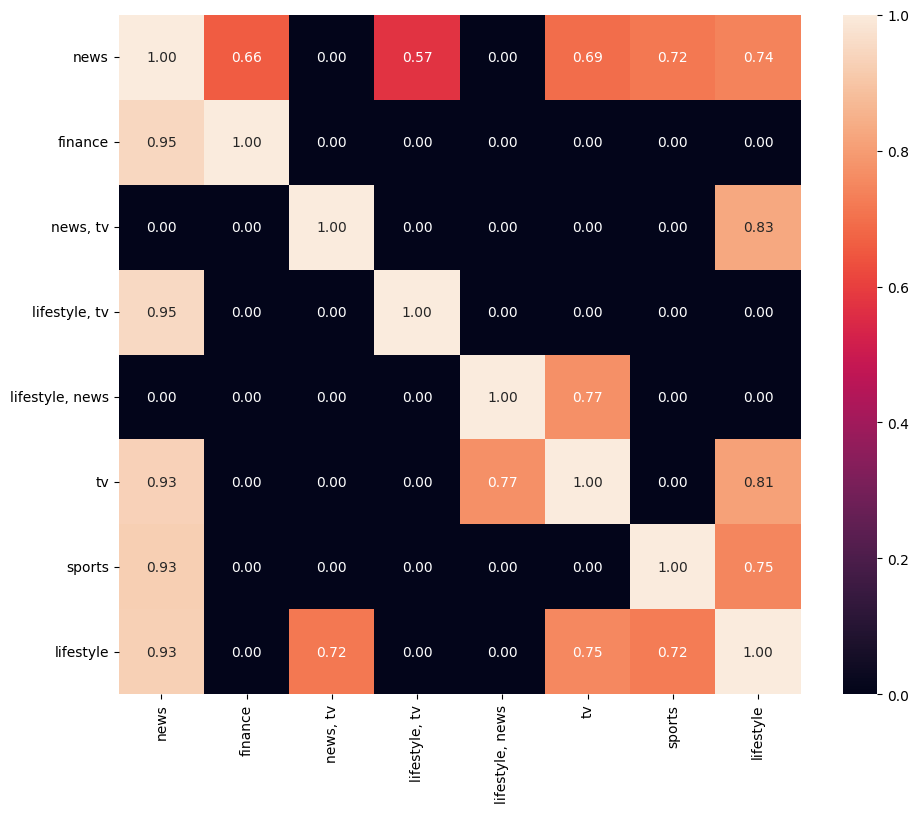

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# 利用置信度绘制热图
conf_matrix = []
rules_column = set()

for i in range(len(measure)):
    rules_column.add(measure[i][0])
# 计算置信度矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(rules)):
                if rules[k][0] == i and rules[k][1] == j:
                    one.append(rules[k][3])
                    flag = True
            if flag == False:
                one.append(0)
    conf_matrix.append(one)
# 改columns名字
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += category[j]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)
# 绘制热图的数据
rules_column = list(rules_column)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += category[list(i)[j]]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)

conf_pd = pd.DataFrame(conf_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = conf_pd, annot = True, fmt = ".2f")
plt.show()

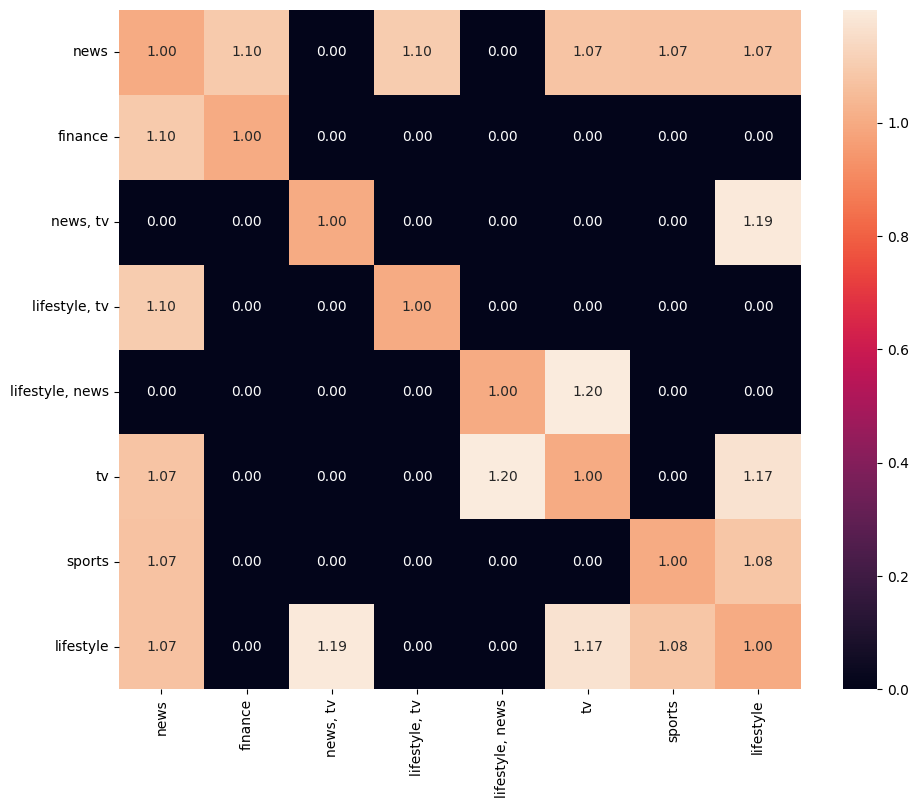

In [37]:
# 使用Lift值绘制热图
# 计算lift矩阵
lift_matrix = []
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(measure)):
                if measure[k][0] == i and measure[k][1] == j:
                    one.append(measure[k][6])
                    flag = True
            if flag == False:
                one.append(0)
    lift_matrix.append(one)

lift_pd = pd.DataFrame(lift_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = lift_pd, annot = True, fmt = ".2f")
plt.show()

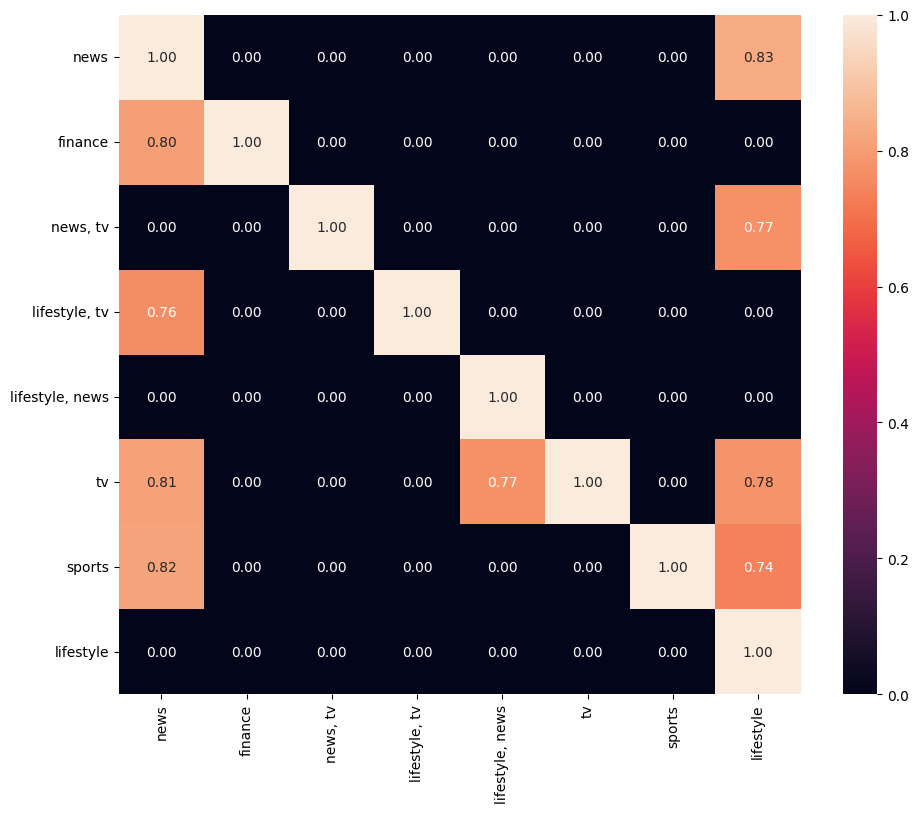

In [38]:
# 使用Kulc值绘制热图
kulc_matrix = []
# 计算kulc矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(kulc)):
                if kulc[k][0] == i and kulc[k][1] == j:
                    one.append(kulc[k][2])
                    flag = True
            if flag == False:
                one.append(0)
    kulc_matrix.append(one)
    
kulc_pd = pd.DataFrame(kulc_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = kulc_pd, annot = True, fmt = ".2f")
plt.show()

# 二、针对YELP数据集的处理

## 1、数据获取与预处理

In [1]:
# import json
# file = open("yelp_academic_dataset_business.json", 'r', encoding='utf-8')
# papers = []
# for line in file.readlines():
#     dic = json.loads(line)
#     papers.append(dic)


# print(len(papers))
# print(papers[0])
# print(papers[1])

import pandas as pd

df = pd.read_json('yelp_academic_dataset_business.json',lines=True)

df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


### 数据预处理
将categories替换和stars为整数格式

In [22]:
df = df.dropna()
id2str = []
str2id = {}
id = 0
transaction = []
for i,row in df.iterrows():
#     print(i, row)
    one = []
    cate = df['categories'][i].split(', ')
    for j in cate:
        if j in str2id:
            one.append(str2id[j])
        else:
            id2str.append(j)
            str2id[j] = len(id2str)
            one.append(str2id[j])
    if df['stars'][i] in str2id:
        one.append(str2id[str(df['stars'][i])])
    else:
        id2str.append(str(df['stars'][i]))
        str2id[str(df['stars'][i])] = len(id2str)
        one.append(str2id[str(df['stars'][i])])
    transaction.append(one)
print(transaction[0:10])
id2str

[[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19], [20, 21, 15, 22], [23, 24, 25, 15, 26, 14, 27], [28, 9, 29, 8, 30, 31, 32], [26, 24, 23, 14, 15, 33], [7, 8, 9, 34], [35, 15, 14, 36, 37], [38, 14, 39, 40, 41]]


['Shipping Centers',
 'Local Services',
 'Notaries',
 'Mailbox Centers',
 'Printing Services',
 '3.0',
 'Department Stores',
 'Shopping',
 'Fashion',
 'Home & Garden',
 'Electronics',
 'Furniture Stores',
 '3.5',
 'Restaurants',
 'Food',
 'Bubble Tea',
 'Coffee & Tea',
 'Bakeries',
 '4.0',
 'Brewpubs',
 'Breweries',
 '4.5',
 'Burgers',
 'Fast Food',
 'Sandwiches',
 'Ice Cream & Frozen Yogurt',
 '2.0',
 'Sporting Goods',
 'Shoe Stores',
 'Sports Wear',
 'Accessories',
 '2.5',
 '1.5',
 '3.5',
 'Vietnamese',
 'Food Trucks',
 '4.0',
 'American (Traditional)',
 'Diners',
 'Breakfast & Brunch',
 '2.5',
 'General Dentistry',
 'Dentists',
 'Health & Medical',
 'Cosmetic Dentists',
 '5.0',
 'Delis',
 'Italian',
 '4.5',
 'Sushi Bars',
 'Japanese',
 '4.0',
 'Automotive',
 'Auto Parts & Supplies',
 'Auto Customization',
 '4.5',
 'Vape Shops',
 'Tobacco Shops',
 'Personal Shopping',
 'Vitamins & Supplements',
 '4.0',
 'Korean',
 '4.5',
 'Cafes',
 'Bars',
 'Wine Bars',
 'Nightlife',
 '4.0',
 'Books'

## 2、频繁模式与关联规则挖掘

使用orangecontrib.associate.fpgrowth包进行频繁模式挖掘。由于关联项集过小因此降低了置信度阈值。

In [27]:
import orangecontrib.associate.fpgrowth as oaf
items_thr = 0.05
rules_thr = 0.05
items = list(oaf.frequent_itemsets(transaction, items_thr))
for i in items:
    print(i)

(frozenset({2}), 9351)
(frozenset({8}), 21053)
(frozenset({14}), 44676)
(frozenset({15}), 23910)
(frozenset({14, 15}), 13816)
(frozenset({17}), 6186)
(frozenset({17, 15}), 6186)
(frozenset({24}), 5959)
(frozenset({24, 14}), 5959)
(frozenset({25}), 7623)
(frozenset({25, 14}), 7623)
(frozenset({38}), 7419)
(frozenset({38, 14}), 7419)
(frozenset({44}), 9821)
(frozenset({53}), 8083)
(frozenset({65}), 9882)
(frozenset({65, 14}), 7713)
(frozenset({67}), 10777)
(frozenset({67, 14}), 8036)
(frozenset({65, 67}), 9882)
(frozenset({65, 67, 14}), 7713)
(frozenset({87}), 6026)
(frozenset({14, 87}), 6026)
(frozenset({118}), 8137)
(frozenset({122}), 12038)
(frozenset({204}), 11760)


In [28]:
items = list(oaf.frequent_itemsets(transaction, items_thr))
rules = list(oaf.association_rules(dict(items), rules_thr))
for i in rules:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, i[2], round(i[3],2))
print(len(rules))

['4.0', 'Food'] -> ['Wine Bars'] 7713 0.96
['4.0'] -> ['Wine Bars', 'Food'] 7713 0.72
['Wine Bars', 'Food'] -> ['4.0'] 7713 1.0
['Food'] -> ['Wine Bars', '4.0'] 7713 0.17
['Wine Bars'] -> ['4.0', 'Food'] 7713 0.78
['Wine Bars', '4.0'] -> ['Food'] 7713 0.78
['Bubble Tea'] -> ['Food'] 13816 0.58
['Food'] -> ['Bubble Tea'] 13816 0.31
['Bubble Tea'] -> ['Bakeries'] 6186 0.26
['Bakeries'] -> ['Bubble Tea'] 6186 1.0
['Food'] -> ['Sandwiches'] 5959 0.13
['Sandwiches'] -> ['Food'] 5959 1.0
['Food'] -> ['Ice Cream & Frozen Yogurt'] 7623 0.17
['Ice Cream & Frozen Yogurt'] -> ['Food'] 7623 1.0
['Food'] -> ['Diners'] 7419 0.17
['Diners'] -> ['Food'] 7419 1.0
['Food'] -> ['Wine Bars'] 7713 0.17
['Wine Bars'] -> ['Food'] 7713 0.78
['Food'] -> ['4.0'] 8036 0.18
['4.0'] -> ['Food'] 8036 0.75
['4.0'] -> ['Wine Bars'] 9882 0.92
['Wine Bars'] -> ['4.0'] 9882 1.0
['Chicken Wings'] -> ['Food'] 6026 1.0
['Food'] -> ['Chicken Wings'] 6026 0.13
24


## 3.关联规则的评价

使用Lift和Kulc两种评价指标评价关联规则。

In [29]:
measure = list(oaf.rules_stats(oaf.association_rules(dict(items), items_thr), dict(oaf.frequent_itemsets(transaction, rules_thr)), len(df)))
for i in measure:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, round(i[6], 2))

['4.0', 'Food'] -> ['Wine Bars'] 11.42
['4.0'] -> ['Wine Bars', 'Food'] 10.91
['Wine Bars', 'Food'] -> ['4.0'] 10.91
['Food'] -> ['Wine Bars', '4.0'] 2.05
['Wine Bars'] -> ['4.0', 'Food'] 11.42
['Wine Bars', '4.0'] -> ['Food'] 2.05
['Bubble Tea'] -> ['Food'] 1.52
['Food'] -> ['Bubble Tea'] 1.52
['Bubble Tea'] -> ['Bakeries'] 4.92
['Bakeries'] -> ['Bubble Tea'] 4.92
['Food'] -> ['Sandwiches'] 2.63
['Sandwiches'] -> ['Food'] 2.63
['Food'] -> ['Ice Cream & Frozen Yogurt'] 2.63
['Ice Cream & Frozen Yogurt'] -> ['Food'] 2.63
['Food'] -> ['Diners'] 2.63
['Diners'] -> ['Food'] 2.63
['Food'] -> ['Wine Bars'] 2.05
['Wine Bars'] -> ['Food'] 2.05
['Food'] -> ['4.0'] 1.96
['4.0'] -> ['Food'] 1.96
['4.0'] -> ['Wine Bars'] 10.91
['Wine Bars'] -> ['4.0'] 10.91
['Chicken Wings'] -> ['Food'] 2.63
['Food'] -> ['Chicken Wings'] 2.63


In [30]:
# 计算Kulc
kulc = []
visit = [False for i in range(len(rules))]
for i in range(len(rules)):
    if visit[i] == True:
        continue
    visit[i] = True
    for j in range(len(rules)):
        if visit[j] == True:
            continue
        if rules[j][0] == rules[i][1] and rules[j][1] == rules[i][0]:
            one = []
            antecedent = []
            consequent = []
            for k in rules[i][0]:
                antecedent.append(id2str[k])
            for k in rules[i][1]:
                consequent.append(id2str[k])
            one.append(rules[i][0])
            one.append(rules[i][1])
            one.append((rules[i][3] + rules[j][3])/2)
            kulc.append(one)
            print('Kulc(', antecedent, consequent, ') = ', round((rules[i][3] + rules[j][3])/2, 2))
            visit[j] = True

Kulc( ['4.0', 'Food'] ['Wine Bars'] ) =  0.87
Kulc( ['4.0'] ['Wine Bars', 'Food'] ) =  0.86
Kulc( ['Food'] ['Wine Bars', '4.0'] ) =  0.48
Kulc( ['Bubble Tea'] ['Food'] ) =  0.44
Kulc( ['Bubble Tea'] ['Bakeries'] ) =  0.63
Kulc( ['Food'] ['Sandwiches'] ) =  0.57
Kulc( ['Food'] ['Ice Cream & Frozen Yogurt'] ) =  0.59
Kulc( ['Food'] ['Diners'] ) =  0.58
Kulc( ['Food'] ['Wine Bars'] ) =  0.48
Kulc( ['Food'] ['4.0'] ) =  0.46
Kulc( ['4.0'] ['Wine Bars'] ) =  0.96
Kulc( ['Chicken Wings'] ['Food'] ) =  0.57


## 4.挖掘结果的分析

所有的24条关联规则中，lift值均大于1。

在所有计算出的关联规则的Kulc值中，以下三个Kulc值较大：

Kulc( ['4.0'] ['Wine Bars'] ) =  0.96

Kulc( ['4.0', 'Food'] ['Wine Bars'] ) =  0.87

Kulc( ['4.0'] ['Wine Bars', 'Food'] ) =  0.86

因此可以得到以下结论：

Wine Bars 通常提供食物且评星在4星

在关联规则中，以下几条的置信度很高，达到了1.0：

['Wine Bars', 'Food'] -> ['4.0'] 7713 1.0

['Bakeries'] -> ['Bubble Tea'] 6186 1.0

['Sandwiches'] -> ['Food'] 5959 1.0

['Diners'] -> ['Food'] 7419 1.0

['Wine Bars'] -> ['4.0'] 9882 1.0

['Chicken Wings'] -> ['Food'] 6026 1.0

## 5.可视化展示

绘制关联规则的置信度、Lift和Kulc相关性热图

横纵坐标是关联规则中包含的项，热图中每个点的数据是两项的置信度、Lift值或Kulc值

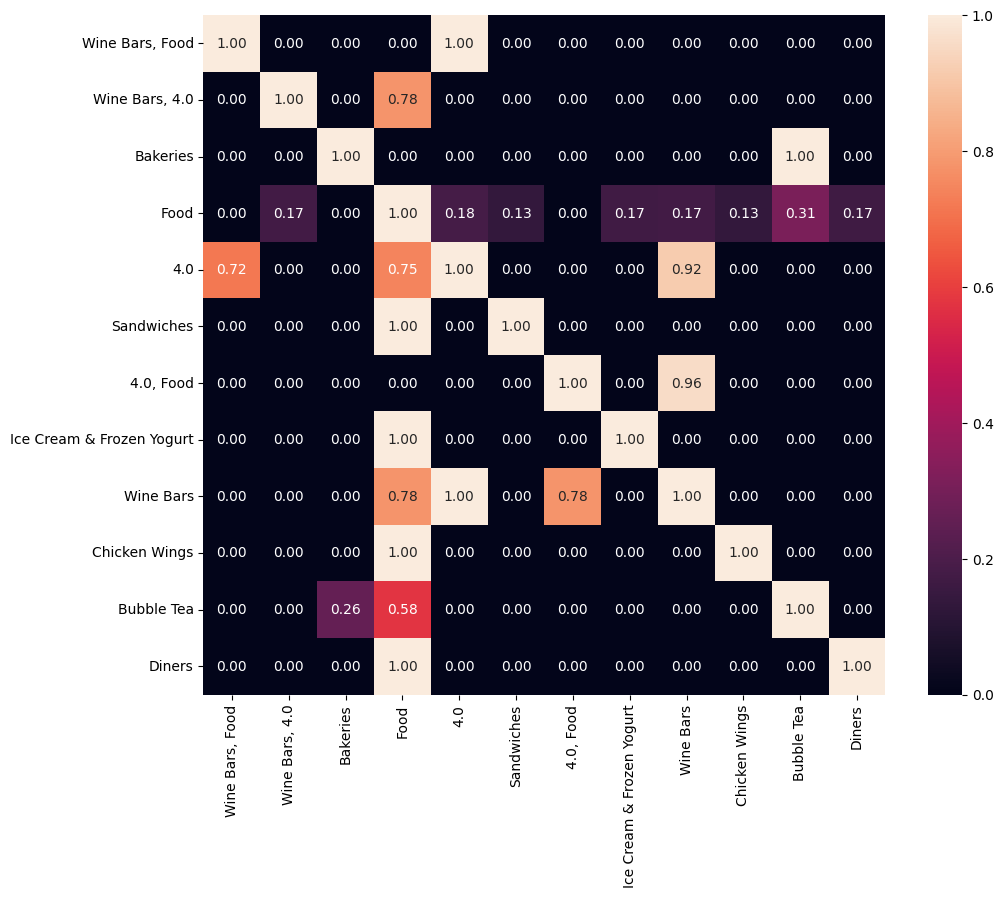

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 利用置信度绘制热图
conf_matrix = []
rules_column = set()

for i in range(len(measure)):
    rules_column.add(measure[i][0])
# 计算置信度矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(rules)):
                if rules[k][0] == i and rules[k][1] == j:
                    one.append(rules[k][3])
                    flag = True
            if flag == False:
                one.append(0)
    conf_matrix.append(one)
# 改columns名字
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[j]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)
# 绘制热图的数据
rules_column = list(rules_column)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[list(i)[j]]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)

conf_pd = pd.DataFrame(conf_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = conf_pd, annot = True, fmt = ".2f")
plt.show()


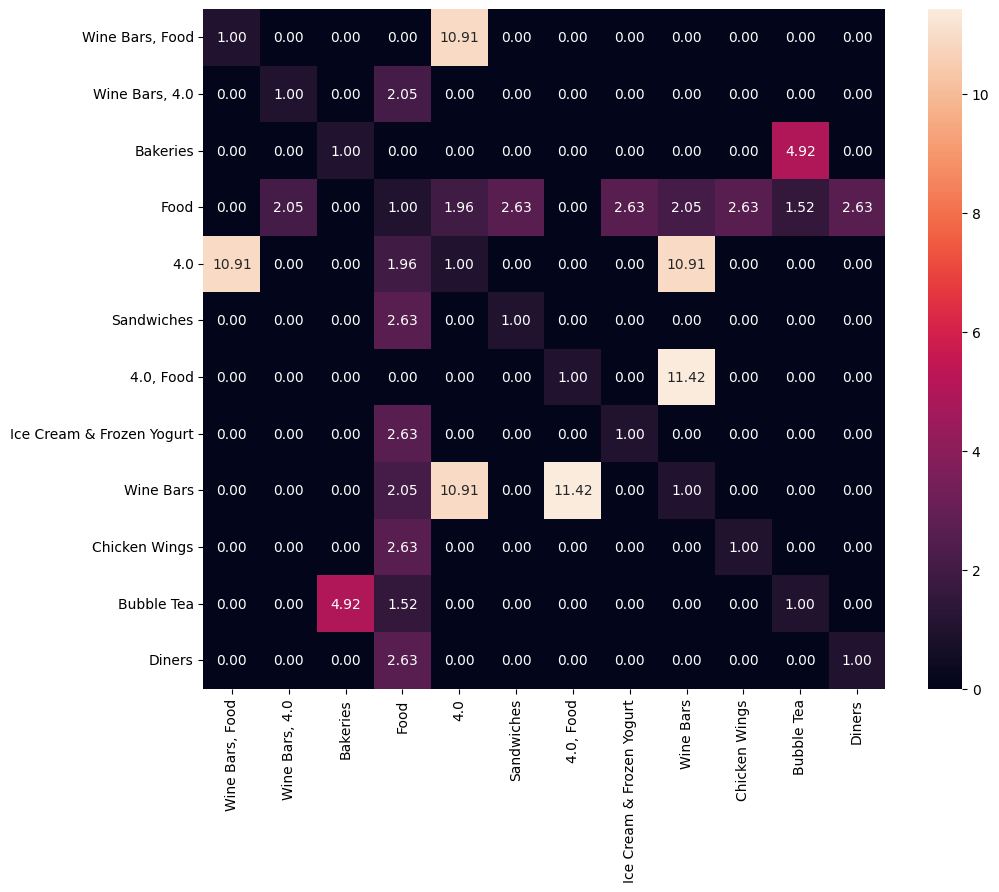

In [33]:
# 使用Lift值绘制热图
# 计算lift矩阵
lift_matrix = []
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(measure)):
                if measure[k][0] == i and measure[k][1] == j:
                    one.append(measure[k][6])
                    flag = True
            if flag == False:
                one.append(0)
    lift_matrix.append(one)

lift_pd = pd.DataFrame(lift_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = lift_pd, annot = True, fmt = ".2f")
plt.show()


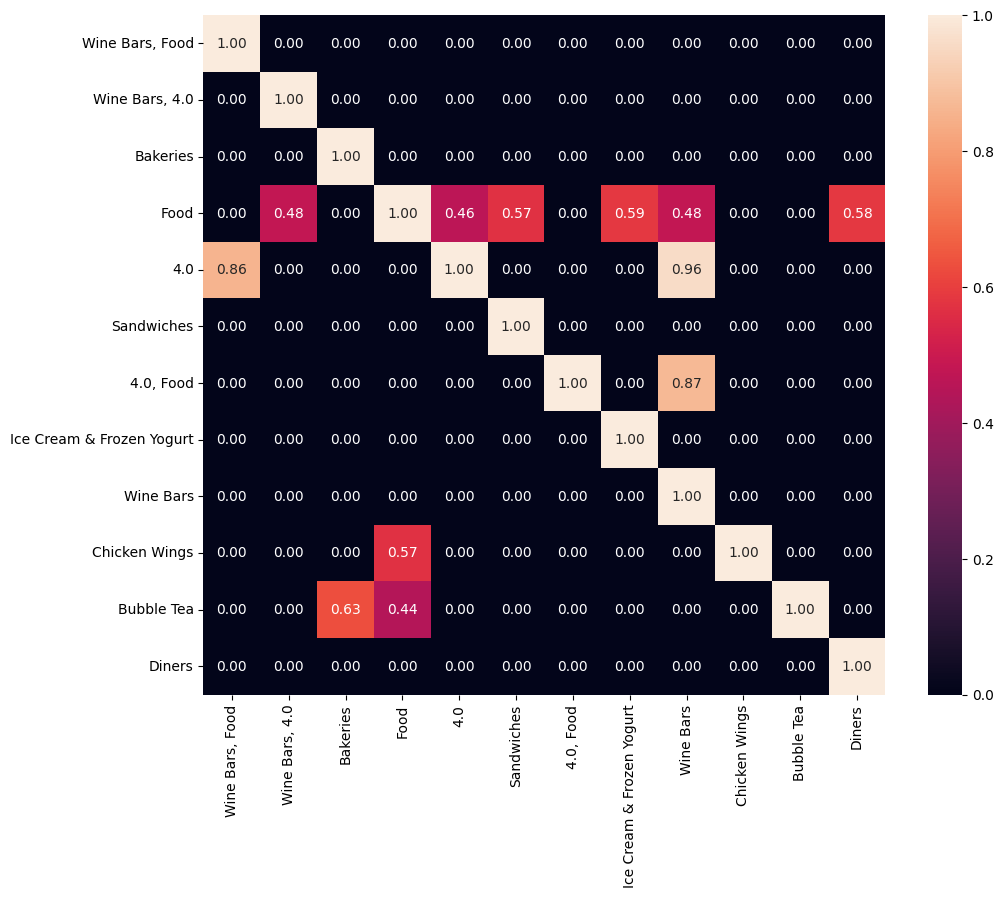

In [34]:
# 使用Kulc值绘制热图
kulc_matrix = []
# 计算kulc矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(kulc)):
                if kulc[k][0] == i and kulc[k][1] == j:
                    one.append(kulc[k][2])
                    flag = True
            if flag == False:
                one.append(0)
    kulc_matrix.append(one)
    
kulc_pd = pd.DataFrame(kulc_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = kulc_pd, annot = True, fmt = ".2f")
plt.show()